## Part III - Portfolio Optimization 

In [1]:
# Import relevant libraries

import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy as sp
import numpy as np 
import math
from scipy.optimize import LinearConstraint
from scipy.optimize import Bounds

# importer l'Excel de prix 

index_df = pd.read_excel('D:\ENSAE\S1\OMI307_Machine Learning en Python\Projet\Reactive-Covariance\Data\Indices.xls') 
index_df.head()

,Date,STOXX 600,STOXX 50,S&P 500,TOPIX,FTSE,DAX,NIKKEI,NASDAQ
0,1990-01-01,108.16,1098.49,353.40,2881.37,2422.7,1778.119995,38915.87109,454.82
1,1990-01-02,108.63,1101.34,359.69,2881.37,2434.1,1788.890015,38915.87109,459.33
2,1990-01-03,110.04,1112.82,358.76,2881.37,2463.7,1867.290039,38915.87109,460.90
3,1990-01-04,110.02,1113.02,355.67,2867.70,2451.6,1830.920044,38712.87891,459.39
4,1990-01-05,109.02,1099.52,352.20,2834.61,2444.5,1812.900024,38274.76172,458.22


### 3.1 - Standard Approach - Mean Variance Optimization
The modern portfolio theory, introduced by H. Markowitz in 1952, states that the optimal allocation between expected return and expected risk is managed through diversification. Such optimal portfolio are achieved by solving the following optimization program:

$$
    \begin{cases}
        \max\limits_{w} w'\mu - \dfrac{\lambda}{2}w'\Omega w
        \\
        1'w=1
    \end{cases}
$$

where $\mu$ correspond to the expected returns of the assets, $\Omega$ the expected variance covariance matrix of asset returns and $\lambda \in \mathbb{R}^{+}$ the investors risk aversion. No sign restriction on the weights yield to an explicit solution given by:

$$
    w = \frac{1}{\lambda}\Omega^{-1}\mu
$$

while restricting the weights for long only portfolio imposed to solve this program numerically.

However, in practice one observes the __Markowitz paradox__ defining highly concentrated portfolio, more focus on the asset expected returns. Thus not efficiently allocating the risk. One solution to this paradox consist of considering risk based approach (introduced in the next section).

In [12]:
portfolio_return     = []
portfolio_volatility = []
efficient_return     = []
efficient_volatility = []
stock_weights        = []

# Combinaisons de portefeuilles 
number_assets  = 8
num_portfolios = 50 # Nombre de simulation de protefeuille 

index_dictionnary = {"0" : "STOXX 600", "1":"STOXX 50","2" : "S&P 500","3" : "TOPIX", "4": "FTSE", "5":"DAX", "6":"NIKKEI","7":"NASDAQ"}
index_returns     = []

In [4]:
def computeExpectedReturns(index_dictionnary):
    expected_return = []
    for key in index_dictionnary:
        Xi = index_dictionnary.get(key)
        n = len(index_df[Xi])
        expected_return.append(((index_df[Xi]-index_df[Xi].shift(1)) /index_df[Xi].shift(1)).dropna().mean()) # moyenne des daily returns annualizés 
    return expected_return 
        
index_return = computeExpectedReturns(index_dictionnary)
#print(index_return)

[0.0002304372539344647, 0.00023872813518222905, 0.00033865221588221255, 1.4147980586776077e-05, 0.0002103253251801626, 0.0003558592689741897, 3.396573947477475e-05, 0.00048147437472486357]


In [5]:
def grossReturn(Xi):
    return (index_df[Xi]/index_df[Xi].shift(1)).dropna()  # dropna() allows to remove the "NaN" from the list

# Retourne la matrice de covariance

def covarianceMatrix(index_dictionnary):
    n = len(index_dictionnary) # Regarde la taille du dictionnaire
    covariance = np.zeros((n,n)) # Création d'une matrice vide de taille n*n pour stocker les valeurs de covariance

    for i in range(0,n):
        for j in range(0,n):
            Xi = index_dictionnary.get(str(i))  # Recupere le nom de la colonne Xi
            Xj = index_dictionnary.get(str(j))  # Recupere le nom de la colonne Xj
            covariance[i][j] = np.cov(grossReturn(Xi),grossReturn(Xj))[0][1] ## Calcule la covariance
    return covariance



In [6]:
def Markowitz(expRet, expCov, riskAversion):
    
    ## Objective function
    def objective(w):
        return -(np.dot(w, expRet)-0.5*riskAversion*np.dot(w, np.dot(expCov,w)))
    
    ## Optimization constraints
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds      = [(0.0,1.0) for asset in range(len(expRet))]
    
    ## Optimization procedure
    spMark      =  sp.optimize.minimize(objective, len(expRet)*[1./len(expRet),],
                        method='SLSQP', bounds=bounds, constraints=constraints)
    ## Output
    return spMark

In [15]:
## Génération de portefeuilles aléatoires

# Expected return is estimated from 1Y return for each asset 

for portfolio_i in range(num_portfolios):
    
    # on randomize le vecteur d'allocation
    allocation = np.random.random(number_assets) 
    
    # Initialisation du vecteur des prix
    price = np.zeros(number_assets)
    
    # Les poids du portefeuille sont calcule "aujourd'hui": on affecte au vecteur "price" la dernière valeur du stock
    for i in range(0,number_assets): 
        Xi = index_dictionnary.get(str(i))
        price[i] = index_df[Xi].tail(1)
    
    wa = np.dot(np.diag(allocation),price)  # On calcule le vecteur de poids avec diag(allocation) * vect(prix)
    wa /= np.sum(wa) # et on normalize le vecteur de poids
    
    # On calcule l'expected return du portefeuille de poids aléatoires 
    returns = np.dot(wa,computeExpectedReturns(index_dictionnary))*250*100
    portfolio_return.append(returns)
    
    # On calcule la volatilité du portefeuille
    volatility = np.sqrt(np.dot(wa.T,np.dot(covarianceMatrix(index_dictionnary),wa)))*np.sqrt(250)*100  ## Ne pas oublier d'annualiser la vol !!!
    portfolio_volatility.append(volatility)
    
returns    = []
volatility = []
for i in range(15):
    optMar  = Markowitz(np.multiply(computeExpectedReturns(index_dictionnary),252), np.multiply(covarianceMatrix(index_dictionnary),252),i/4)
    weff    = optMar.x
    
    returns = np.dot(weff,computeExpectedReturns(index_dictionnary))*250*100
    efficient_return.append(returns)
    
    volatility = np.sqrt(np.dot(weff.T,np.dot(covarianceMatrix(index_dictionnary),weff)))*np.sqrt(250)*100  ## Ne pas oublier d'annualiser la vol !!!
    efficient_volatility.append(volatility)


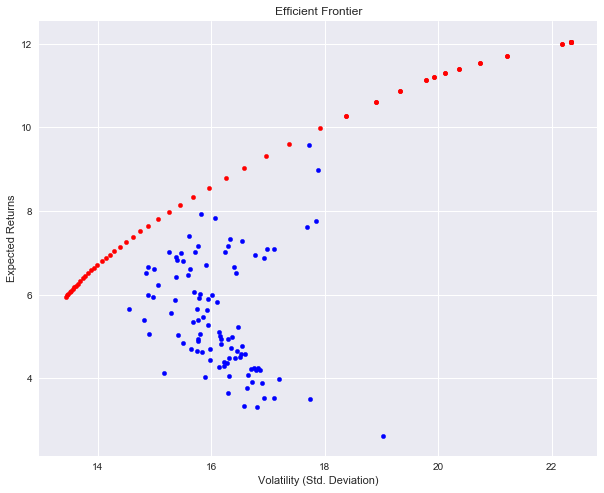

In [16]:
portfolio = {"Returns": portfolio_return, "Volatility" : portfolio_volatility} # Création d'un dictionnaire pour stocker les valeurs
result_df = pd.DataFrame(portfolio) # conversion en dataframe

efficient    = {"Returns": efficient_return, "Volatility" : efficient_volatility} # Création d'un dictionnaire pour stocker les valeurs
efficient_df = pd.DataFrame(efficient) # conversion en dataframe

#print(result_df)
plt.style.use('seaborn')
ax1 = result_df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True,c='Blue')
efficient_df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True,c='Red', ax=ax1)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

### 3.2 - Risk Based Approach
In this section we implement an unified framework for risk based portfolio allocation (see J-C. Richard and T. Roncalli, _Smart Beta: Managing Diversification of Minimum Variance Portfolios_, 2015). Lets consider the following optimization program:

$$
    \begin{cases}
        \min\limits_{w} \frac{1}{2}w'\Omega w
        \\
        \mathcal{D}(w;\gamma)\geq c_{1}
        \\
        \mathcal{B}(w;\delta) = c_{2}
        \\
        x \geq 0
    \end{cases}
$$

where 
\begin{align*}
    \mathcal{D}(w;\gamma) &= \gamma\sum\limits_{i=1}^{N}\log x_{i} - (1-\gamma)\sum\limits_{i=1}^{N}x_{i}^{2}
    \\
    \mathcal{B}(w;\delta) &= \delta\sum\limits_{i}^{N}x_{i}+(1-\delta)\sum\limits_{i=1}^{N}x_{i}\sigma_{i}
\end{align*}
and $\gamma \in [0,1]$ controls the weights and risk diversification and $\delta \in [0,1]$ controls the budget allocation. One can omit (without losses) the constant $(c_{1},c_{2})$ by the following restricted form of the optimization programs:

$$
    \begin{cases}
        \min\limits_{w} \frac{1}{2}w'\Omega w - \lambda \mathcal{D}(w;\gamma) + (\lambda-1)\mathcal{B}(w;\delta) 
        \\
        w \geq 0
    \end{cases}
$$

with $\lambda \geq 0$ controlling the diversification impact. This optimization program is wide enought to include the risk parity portfolio (ERC), most diversified portfolio (MDP) and the global minimum variance portfolio (GMV) :

|        | $\lambda$ | $\gamma$ | $\delta$ |
|--------|-----------|----------|----------|
|   ERC  |     1     |     1    |     0    |
|   MDP  |     0     |          |     0    |
|   GMV  |     0     |          |     1    |

The previous Lagrangian can easily estimated using a Cyclical Coordinate Descent algorihtm which is higly efficient for high dimensionnal problems compare to classic Newton approach (see T. Griveau-Billion , J-C. Richard and T. Roncalli, _A Fast Algorithm for Computing High-dimensional Risk Parity Portfolios_, 2013).

__Individual optimization programs__:

|GMV|ERC|MDP|
|:-:|:-:|:-:|
|$\begin{cases} \min\limits_{w} \dfrac{1}{2}w'\Omega w \\ 1'w = 1 \\ w \geq 0 \end{cases}$ |$\begin{cases} \min\limits_{w} \dfrac{1}{2}w'\Omega w \\ \sum\limits_{i=1}^{N}\log w_{i} \geq c \\ 1'w = 1 \\ w \geq 0 \end{cases}$|$\begin{cases} \min\limits_{w} \dfrac{w'\sigma}{\sqrt{w'\Omega w}} \\ 1'w = 1 \\ w \geq 0 \\ \sigma = \lbrace \sigma_{i} \rbrace_{i \in \mathbb{N}} \end{cases}$|


In [20]:
# Set the achievable portfolio
PortType  = {'MDP':[0.0, 0.0, 0.0], 'ERC':[1.0, 1.0, 0.0], 'GMV':[0.0, 0.0, 1.0]}
# Optimization options (tolerance criterion, maximum iteration)
optoption = [10^-15, 2000]

In [18]:
def RiskBasedPortfolio(omega, ptftype, optoption):    
    
    ## Optimization option
    tol     = optoption[0] # Convergence criterion
    maxiter = optoption[1] # Number of maximum iteration
    
    ## Portfolio type
    lambd = ptftype[0] # Allocation between Diversification and Budget constraints.
    gamma = ptftype[1] # Allocation between risk parity and maximum diversification.
    delta = ptftype[2] # Allocation between minimum variance and the most diversified portfolio.

    ## Dimension
    nvar = len(omega[0])

    ## Output pre-allocation
    x  = [[0 for col in range(nvar)] for row in range(maxiter+1)] # Solution at the k-th iteration.
    xu = [0 for col in range(nvar)]                               # Update solution
    k  = 0                                                        # k-th Iteration
    
    ## Initialization
    # Set an equal weighted portfolio at the 1-st iteration
    xk   = [(1/nvar) for col in range(nvar)]
    x[0] = xk

    # Compute the total portfolio risk
    omegaxk = np.matmul(omega,xk)

    # Set the convergence condition to false
    check = False
    
    ## Iterative process
    while ((check==False) and (k<maxiter)):
        # Loop over the weights
        for i in range(nvar):
            # Update the i-th weights
            a     = omega[i][i] + 2.0*lambd*(1-gamma)
            b     = omegaxk[i] - xk[i]*omega[i][i]\
                  - delta*(1.0-lambd)\
                  - (1.0-lambd)*(1.0-delta)*math.sqrt(omega[i][i])
            c     = (-1.0)*lambd*gamma
            disc  = (b**2)-4.0*a*c
            xu[i] = float(-b+math.sqrt(disc))/float(2.0*a)

            # Update the portfolio volatility
            omegaxk = np.add(np.subtract(omegaxk,np.multiply(omega[:,i],xk[i])),np.multiply(omega[:,i],xu[i]))
  
        # Check the convergence
        check = np.sum(np.absolute(np.subtract(xu,xk)))<tol
        # Increment the iteration control
        k = k + 1
    
        # Weights at the k-th iteration
        x[k] = xu
    
        # Reset the algorithm
        xk   = xu[:]

    ## Final step
    # Normalize the weights to satisfy the budgetary constraint
    xsol = np.multiply(xk,float(1.0/float(np.sum(xk))))
    
    # Return the optimal allocation
    return xsol

__Weights allocation:__

The figure below represents the weights of the different allocation methods. As introduced in the previous section one can see that the Markowitz portfolio (MAR) is the most concentrated while risk based allocation method offers a better weights diversification. The equal risk contribution present the best weights diversication since it requires that each asset contribute equally to the global portfolio risk.

Text(0.5,1,'Weights allocation')

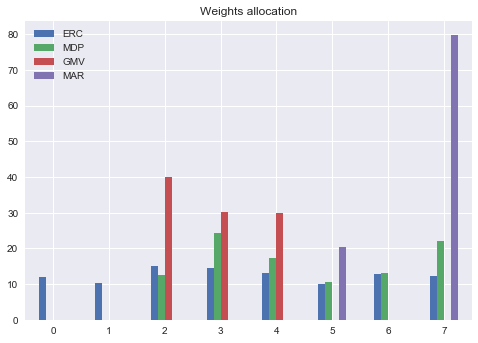

In [21]:
omega = covarianceMatrix(index_dictionnary)

werc = RiskBasedPortfolio(omega, PortType['ERC'], optoption)
wmdp = RiskBasedPortfolio(omega, PortType['MDP'], optoption)
wgmv = RiskBasedPortfolio(omega, PortType['GMV'], optoption)
wmar = Markowitz(np.multiply(computeExpectedReturns(index_dictionnary),252), np.multiply(covarianceMatrix(index_dictionnary),252),2)

df = pd.DataFrame({'ERC': 100*werc, 'MDP': 100*wmdp, 'GMV': 100*wgmv, 'MAR':100*wmar.x}, index=range(len(omega[0])))
ax = df.plot.bar(rot=0)
plt.title("Weights allocation")